# Similarity Detection

## 1. Set Root Repo Directory

In [1]:
import os

In [2]:
root_repo_dir = os.path.normpath("/home/rdbt/Projects_/datathon/2022-Datathon-SAA-Challenge-main")
data_dir = os.path.join(root_repo_dir,"dataset")
transformed_data_dir = os.path.join(data_dir,"transformed")
covid_data_set_path = os.path.join(data_dir, "COVID-19 FAQs | Allianz Global Assistance.json")
travel_data_set_path = os.path.join(data_dir, "Travel Insurance FAQs | Allianz Global Assistance.json")
pred_dir = os.path.join(root_repo_dir, "predictions")

## 2. Imports

In [3]:
import os
import re
import ast
import copy
import time
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from pprint import pprint
import mapply
mapply.init(
    n_workers=-1,
    chunk_size=1000,
    max_chunks_per_worker=8,
    progressbar=True
)

In [4]:
import seaborn as sns
import matplotlib.pylab as plt
import plotly.express as px
import plotly.io as pio
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
%matplotlib inline
pio.renderers.default = 'jupyterlab' 

In [5]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
import torch

In [7]:
import fasttext
import fasttext.util

In [8]:
from sentence_transformers import SentenceTransformer, util

In [9]:
from transformers import AutoTokenizer, AutoModel, AutoConfig

## 3. Read data

In [10]:
nrows = None # 1000 # None
if nrows:
    covid_df = pd.read_json(covid_data_set_path, nrows=nrows)
    travel_df = pd.read_json(travel_data_set_path, nrows=nrows)
else:
    covid_df = pd.read_json(covid_data_set_path)
    travel_df = pd.read_json(travel_data_set_path)

In [11]:
covid_df = pd.json_normalize(covid_df['FaqDocuments'])
travel_df = pd.json_normalize(travel_df['FaqDocuments'])

In [12]:
df = pd.concat([covid_df, travel_df], axis=0)

In [13]:
df.head()

,Question,Answer
0,I am worried about COVID-19 impacting a trip I...,COVID-19 is a known and evolving epidemic that...
1,Am I covered if I want to cancel my travel pla...,"No, canceling a trip because you’re afraid to ..."
2,Am I covered if I cancel or interrupt my trip ...,"Claims due to known, foreseeable, or expected ..."
3,"What if my travel supplier (e.g. airline, crui...",Travel supplier cancellations due to COVID-19 ...
4,Am I covered if I cancel my travel plans becau...,"No, canceling a trip because of a travel ban o..."


In [14]:
df.shape

(81, 2)

## 4. Preprocess the text

In [15]:
stop_words = set(stopwords.words('german'))
stemmer = WordNetLemmatizer()

In [16]:
def preprocess(sent):
    # Remove all the special characters
    sent = re.sub(r'\W', ' ', sent)
    # remove all single characters
    sent = re.sub(r'\s+[a-zA-Z]\s+', ' ', sent)
    # Remove single characters from the start
    sent = re.sub(r'\^[a-zA-Z]\s+', ' ', sent) 
    # Substituting multiple spaces with single space
    sent = re.sub(r'\s+', ' ', sent, flags=re.I)
    # Removing prefixed 'b'
    sent = re.sub(r'^b\s+', '', sent)
    # Converting to Lowercase
    sent = sent.lower()

    text_tokens = word_tokenize(sent)
    sent = [stemmer.lemmatize(word)  for word in text_tokens if not word in stop_words]
    sent = (" ").join(sent)

    return sent

In [17]:
df["Question"] = df['Question'].apply(preprocess)
df["Answer"] = df['Answer'].apply(preprocess)

## 5. Modeling

In [18]:
def compute_similarity(a, b):
#     cos_scores = util.pytorch_cos_sim(ef_emd, tar_emb)
    cos_scores = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_scores

In [19]:
def get_similarity(qs_emb_list, an_emb_list, shuffle=False):
    if shuffle:
        random.shuffle(an_emb_list)
    sim_list = []
    for qs_emb, an_emb in zip(qs_emb_list, an_emb_list):
        sim = compute_similarity(qs_emb, an_emb)
        sim_list.append(sim)
    return sim_list

In [20]:
def show_sim_hist(self_sim_scores_list, cross_sim_scores_list):
    fig = plt.figure()
    plt.hist(self_sim_scores_list, label='Self Similarity', alpha=0.3)
    plt.hist(cross_sim_scores_list, label='Cross Similarity', alpha=0.3)
    plt.legend(loc="upper right")
    plt.title(f'Histogram of the similarity scores')
    plt.show()

In [21]:
def compute_embeddings(df, tokenizer=None, model=None, batch_size=16, model_name="hf"):
    qs_sent_list = df['Question'].values.tolist()
    an_sent_list = df['Answer'].values.tolist()

    num_batchs = int(len(df)/batch_size) + 1
    qs_emb_list = []
    an_emb_list = []
    for i in range(num_batchs):
        batch_qs = qs_sent_list[i*batch_size:(i+1)*batch_size]
        batch_an = an_sent_list[i*batch_size:(i+1)*batch_size]
        
        if model_name == "st":
            qs_emb_batch = model.encode(batch_qs, convert_to_tensor=True)
            an_emb_batch = model.encode(batch_an, convert_to_tensor=True)
            
        elif model_name == "hf":
            inputs_qs_embs = tokenizer(batch_qs, padding=True, truncation=True, return_tensors="pt")
            outputs_qs_embs = model(**inputs_qs_embs)
            qs_emb_batch = outputs_qs_embs.pooler_output
            
            inputs_an_embs = tokenizer(batch_an, padding=True, truncation=True, return_tensors="pt")
            outputs_an_embs = model(**inputs_an_embs)
            an_emb_batch = outputs_an_embs.pooler_output
        
        elif model_name == "ft":
            qs_sent_emb = np.asarray([model.get_word_vector(x) for x in qs_sent.split()])
            an_sent_emd = np.asarray([model.get_word_vector(x) for x in an_sent.split()])
            
        qs_emb_batch = qs_emb_batch.cpu().detach().numpy().tolist()
        qs_emb_list.extend(qs_emb_batch)
        
        an_emb_batch = an_emb_batch.cpu().detach().numpy().tolist()
        an_emb_list.extend(an_emb_batch)
    
    return qs_emb_list, an_emb_list

In [22]:
batch_size = 16

### FastText

In [ ]:
# load and instantiate the fasttext model
fasttext.util.download_model('en', if_exists='ignore')
ft_model = fasttext.load_model('cc.en.300.bin')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Sentece transformer

In [24]:
def st_get_and_show_similarity(batch_size, show=True):
    model_checkpoints = 'stsb-roberta-large'
    model = SentenceTransformer(model_checkpoints)
    qs_emb_list, an_emb_list = compute_embeddings(df, model=model, batch_size=batch_size, model_name="st")
    self_sim_scores_list = get_similarity(qs_emb_list, an_emb_list, shuffle=False)
    cross_sim_scores_list = get_similarity(qs_emb_list, an_emb_list, shuffle=True)
    
    if show:
        show_sim_hist(self_sim_scores_list, cross_sim_scores_list)
        
    return model, qs_emb_list, an_emb_list

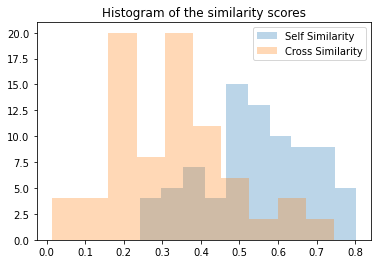

In [25]:
model, qs_emb_list, an_emb_list = st_get_and_show_similarity(batch_size, show=True)

### Husggingfase

In [26]:
def load_hf_model(model_checkpoint, tokenizer_checkpoint):
    model = AutoModel.from_pretrained(model_checkpoint)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)
    return model, tokenizer

In [27]:
def hf_get_show_similarity(batch_size, show=True):
    model_checkpoint = tokenizer_checkpoint = "ProsusAI/finbert"
    model, tokenizer = load_hf_model(model_checkpoint, tokenizer_checkpoint)
    qs_emb_list, an_emb_list = compute_embeddings(df, tokenizer=tokenizer, model=model, batch_size=batch_size, model_name="hf")
    
    self_sim_scores_list = get_similarity(qs_emb_list, an_emb_list, shuffle=False)
    cross_sim_scores_list = get_similarity(qs_emb_list, an_emb_list, shuffle=True)
    
    if show:
        show_sim_hist(self_sim_scores_list, cross_sim_scores_list)
        
    return model, an_emb_list

In [28]:
#model, qs_emb_list, an_emb_list = hf_get_show_similarity(batch_size, show=True)

## Q&A

In [29]:
df["Answer_Emb"] = an_emb_list
df["Question_Emb"] = qs_emb_list

In [30]:
def sample_from_questions_(df, num_sample_queries=5):
    num_ans = len(df)
    random_sample_inds = np.random.randint(low=0, high=num_ans, size=num_sample_queries)
    sample_queries = [df.iloc[i]['Question'] for i in random_sample_inds]
    true_answers = [df.iloc[i]['Answer'] for i in random_sample_inds]
    return sample_queries, true_answers

In [31]:
def sample_from_questions(df, num_sample_queries=5):
    num_ans = len(df)
    random_sample_inds = np.random.randint(low=0, high=num_ans, size=num_sample_queries)
    sampled_df = df.iloc[random_sample_inds]
    return sampled_df

In [32]:
num_ans = len(df)

In [33]:
sampled_df = sample_from_questions(df, num_sample_queries=5)

In [36]:
num_top_answers = 1 # = M
for i, row in sampled_df.iterrows():
    query_sent = row['Question']
    query_emb = row['Question_Emb']
    true_answer = row['Answer']
    true_answer_emb = row['Answer_Emb']
    true_sim_score = get_similarity([query_emb], [true_answer_emb], shuffle=False)
    print(f"question: \n{query_sent}")
    print(f"true_answer: \n{true_answer}")
    print(f"true_sim_score: \n{true_sim_score[0]}")
    
#     df_ = df[df.index!=i]
    cross_sim_score = get_similarity([query_emb]*num_ans, df['Answer_Emb'].values, shuffle=False)
    max_score = np.max(cross_sim_score)
    max_score_ind = np.argmax(cross_sim_score)
    max_answer = df.iloc[max_score_ind]['Answer']
    
    print('-----------------------')
    print(f"predicted_answer: \n{max_answer}")
    print(f"predicted_score: \n{max_score}")
    
    print("########################################################")

question: 
my travel plan have changed how can change my plan coverage date
true_answer: 
we are happy to help you change your coverage date to match your new trip date your new return date must be within 770 day of when you purchased your policy if you have not already departed on your trip or filed claim you may update your plan through the online plan management tool if the travel date have passed and you have not started your trip or filed claim just send u the following information proof of cancellation for your existing trip such copy of the cancellation email from your travel supplier or screenshots from the supplier website copy of your new itinerary showing the traveler name trip date and new total cost of your trip forward your document to agentservices allianzassistance com please include date change request and your plan number the subject line of the email you can fax the document to 804 673 1598 please include your plan number on all document once we receive these item ou

In [ ]:
# def top_answers_finder(model, an_emb_list, query_sent, M=10):
#     query_emb = model.encode(query_sent, convert_to_tensor=True)
#     query_emb = query_emb.cpu().detach().numpy().tolist()
#     query_ans_sim = get_similarity(query_emb, np.transpose(an_emb_list))[0]
#     top_answers_inds = np.argpartition(-query_ans_sim, range(M))[0:M]
#     return top_answers, query_ans_sim

In [ ]:
# num_top_answers = 1 # = M
# for i, sample_query in enumerate(sample_queries):
#     print(f'\n... Get the top {num_top_answers} answers for the sample query {i} which is: ')
#     print(f"Sample query:\n{sample_query}")
#     print(f"True answer is:\n{true_answers[i]}")
    
#     top_answers_inds, query_ans_sim = top_answers_finder(model, an_emb_list, sample_query, M=num_top_answers)
#     print(f"\n... Top {num_top_answers} similar event_descriptions are:\n")
#     for j, ind in enumerate(top_answers_inds):
#         print(f"{j+1}: (Score: {query_ans_sim[j]:1.4})")
#         print(f"Predicted answer is: \n{df.iloc[top_answers_inds[j]]['Answer']}\n")
#         print('--------------------------------------------------')